In [1]:
# NOTE: PLEASE MAKE SURE YOU ARE RUNNING THIS IN A PYTHON3 ENVIRONMENT

import tensorflow as tf
print(tf.__version__)

# This is needed for the iterator over the data
# But not necessary if you have TF 2.0 installed
#!pip install tensorflow==2.0.0-beta0


tf.enable_eager_execution()

# !pip install -q tensorflow-datasets

1.14.0


In [2]:
import tensorflow_datasets as tfds
imdb, info = tfds.load("imdb_reviews", with_info=True, as_supervised=True)


W0731 12:21:24.563737 139721774561152 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow_datasets/core/file_format_adapter.py:209: tf_record_iterator (from tensorflow.python.lib.io.tf_record) is deprecated and will be removed in a future version.
Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/0.1.0. Subsequent calls will reuse this data.


W0731 12:22:26.196544 139721774561152 dataset_builder.py:397] Warning: Setting shuffle_files=True because split=TRAIN and shuffle_files=None. This behavior will be deprecated on 2019-08-06, at which point shuffle_files=False will be the default for all splits.


In [0]:
import numpy as np

train_data, test_data = imdb['train'], imdb['test']

training_sentences = []
training_labels = []

testing_sentences = []
testing_labels = []

# str(s.tonumpy()) is needed in Python3 instead of just s.numpy()
for s,l in train_data:
  training_sentences.append(str(s.numpy()))
  training_labels.append(l.numpy())
  
for s,l in test_data:
  testing_sentences.append(str(s.numpy()))
  testing_labels.append(l.numpy())
  
training_labels_final = np.array(training_labels)
testing_labels_final = np.array(testing_labels)


In [0]:
vocab_size = 10000
embedding_dim = 16
max_length = 120
trunc_type='post'
oov_tok = "<OOV>"


from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(training_sentences)
padded = pad_sequences(sequences,maxlen=max_length, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences,maxlen=max_length)



In [5]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

print(decode_review(padded[1]))
print(training_sentences[1])

b i saw this film on true movies which automatically made me <OOV> but actually it was good why not because of the amazing plot twists or breathtaking dialogue of which there is little but because actually despite what people say i thought the film was accurate in it's depiction of teenagers dealing with <OOV> br br it's not <OOV> creek they're not <OOV> cool witty characters who <OOV> through sexuality with <OOV> knowledge they're kids and they act like kids would br br they're blunt awkward and annoyingly confused about everything yes this could be by accident and they could just be bad actors but i don't think so <OOV> <OOV> gives when not trying to be cool a
b"I saw this film on True Movies (which automatically made me sceptical) but actually - it was good. Why? Not because of the amazing plot twists or breathtaking dialogue (of which there is little) but because actually, despite what people say I thought the film was accurate in it's depiction of teenagers dealing with pregnancy.

In [8]:
# Model Definition with Conv1D
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Conv1D(128, 5, activation='relu'),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 120, 16)           160000    
_________________________________________________________________
conv1d (Conv1D)              (None, 116, 128)          10368     
_________________________________________________________________
global_average_pooling1d (Gl (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 774       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 7         
Total params: 171,149
Trainable params: 171,149
Non-trainable params: 0
_________________________________________________________________


In [9]:
num_epochs = 50
history = model.fit(padded, training_labels_final, epochs=num_epochs, validation_data=(testing_padded, testing_labels_final))

Train on 25000 samples, validate on 25000 samples
Epoch 1/50
25000/25000 [==============================] - 12s 461us/sample - loss: 0.4348 - acc: 0.7890 - val_loss: 0.3453 - val_acc: 0.8469
Epoch 2/50
25000/25000 [==============================] - 9s 362us/sample - loss: 0.2758 - acc: 0.8872 - val_loss: 0.3741 - val_acc: 0.8378
Epoch 3/50
25000/25000 [==============================] - 9s 364us/sample - loss: 0.2233 - acc: 0.9120 - val_loss: 0.3795 - val_acc: 0.8352
Epoch 4/50
25000/25000 [==============================] - 9s 357us/sample - loss: 0.1783 - acc: 0.9337 - val_loss: 0.4293 - val_acc: 0.8296
Epoch 5/50
25000/25000 [==============================] - 9s 354us/sample - loss: 0.1433 - acc: 0.9499 - val_loss: 0.5086 - val_acc: 0.8239
Epoch 6/50
25000/25000 [==============================] - 9s 368us/sample - loss: 0.1138 - acc: 0.9628 - val_loss: 0.5493 - val_acc: 0.8194
Epoch 7/50
25000/25000 [==============================] - 9s 374us/sample - loss: 0.0868 - acc: 0.9738 - val_

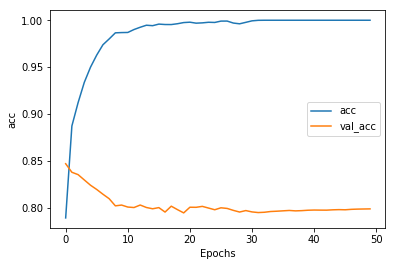

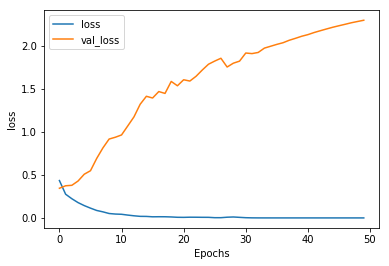

In [14]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, 'acc')
plot_graphs(history, 'loss')

The 2 models below took forever to run, so I'll just stick with Conv1D

In [15]:
# Model Definition with LSTM
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 120, 16)           160000    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                12544     
_________________________________________________________________
dense_4 (Dense)              (None, 6)                 390       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 7         
Total params: 172,941
Trainable params: 172,941
Non-trainable params: 0
_________________________________________________________________


In [6]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(32)),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 120, 16)           160000    
_________________________________________________________________
bidirectional (Bidirectional (None, 64)                9408      
_________________________________________________________________
dense (Dense)                (None, 6)                 390       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 7         
Total params: 169,805
Trainable params: 169,805
Non-trainable params: 0
_________________________________________________________________
